# Third Neural Network
This file contains code to run a third neural network on the dataset. All columns were used because the second neural network showed that the extra data improved results. 

The columns that were categorical were one hot encoded. 3 columns were changed to numeric instead of categorical, which were "age_group", "apr_risk_of_mortality", and "apr_severity_of_illness". However, only converting age group to numeric produced the best results for numeric encoding, so the other 2 numeric mappings are commented out.

The model was evaluated using the metrics of Mean Squared Error and Mean Absolute Error. Additionally, there are multiple visualizations to show the model's performance. We experiemented with number of epochs, validation splits, batch size, and layers to find the best settings (current).

The main purpose of the file is to run a third neural network on the data to see if converting certain columns to numeric improved upon the second neural network in predicting length of stay. This was the best model when there was no numeric encoding, batch size of 32, less than 21 days dataset, all features used, one input layer, two layers.Dense(64, activation='relu'),one layers.Dense(32, activation='relu'), and one output layer.

In [ ]:
# Load libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# visualizations
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats
import seaborn as sns
import numpy as np

In [ ]:
# Load in dataset (the 21 days or less length of stay dataset brought the best results)
df = pd.read_csv('hospital_los_21.csv')

### Code Maps to Convert Ordinal Columns to Numeric Values

In [ ]:
# Define mapping
code_map = {
    "0 to 17":      0,
    "18 to 29":     1,
    "30 to 49":     2,
    "50 to 69":     3,
    "70 or Older":  4
}

# Map the age group to a numerical code
df["age_group_code"] = df["age_group"].map(code_map)

# Quick check of the result
print(df[["age_group", "age_group_code"]].head())


     age_group  age_group_code
0     18 to 29               1
1  70 or Older               4
2     50 to 69               3
3     50 to 69               3
4      0 to 17               0


In [63]:
# mortality_risk_code_map = {
#    "Minor":      0,
#    "Moderate":     1,
#    "Major":     2,
#    "Extreme":     3,
# }
# df["apr_risk_of_mortality_code"] = df["apr_risk_of_mortality"].map(mortality_risk_code_map)
# # 4. Quick check
# print(df[["apr_risk_of_mortality", "apr_risk_of_mortality_code"]].head())


In [64]:
# illness_severity_code_map = {
#    "Minor":      0,
#    "Moderate":     1,
#    "Major":     2,
#    "Extreme":     3,
# }
# df["apr_severity_of_illness_description_code"] = df["apr_severity_of_illness_description"].map(illness_severity_code_map)
# # 4. Quick check
# print(df[["apr_severity_of_illness_description", "apr_severity_of_illness_description_code"]].head())

### Preparing Data

In [ ]:
# Define features (both categoric and numeric) as well as target variable
categorical_features = [
    "gender",
    "type_of_admission", 
    "ccsr_diagnosis_description",
    "ccsr_procedure_description",
    "apr_drg_description",
    "apr_medical_surgical_description",
    "emergency_department_indicator",
    "apr_mdc_description",
    "apr_severity_of_illness_description",
     "apr_risk_of_mortality"
]
numeric_features = [
    "age_group_code",    
]
target = "length_of_stay"
X = df[categorical_features + numeric_features]
y = df[target]



In [ ]:
# One hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)
X_encoded = preprocessor.fit_transform(X)



In [ ]:
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

## Building the Simple Dense Neural Network

In [68]:
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),     # input layer
    layers.Dense(64, activation='relu'), # hidden layer 1,
    layers.Dense(64, activation ='relu'), # hidden layer 2
    layers.Dense(32, activation ='relu'),
     layers.Dense(32, activation ='relu'), # hidden layer 3
    layers.Dense(1)                      # output layer for regression
])
model.compile(
    optimizer='adam',
    loss='mse', # mean squared error
    metrics=['mae'] # mean absolute error
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │        74,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,081 (320.63 KB)

 Trainable params: 82,081 (320.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping to prevent overfitting
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2, # hold out 20% of train for validation
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
14546/14546 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - loss: 10.6196 - mae: 2.1828 - val_loss: 9.8480 - val_mae: 2.1138
Epoch 2/10
14546/14546 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 9.7394 - mae: 2.0805 - val_loss: 9.7072 - val_mae: 2.0939
Epoch 3/10
14546/14546 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 9.6481 - mae: 2.0656 - val_loss: 9.7339 - val_mae: 2.1037
Epoch 4/10
14546/14546 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 9.5051 - mae: 2.0515 - val_loss: 9.6636 - val_mae: 2.0602
Epoch 5/10
14546/14546 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 9.4200 - mae: 2.0422 - val_loss: 9.6742 - val_mae: 2.0639
Epoch 6/10
14546/14546 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 9.4148 - mae: 2.0410 - val_loss: 9.8075 - val_mae: 2.1240
Epoch 7/10
14546/14546 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 9.3475 - mae: 2.0317 - val_loss: 9.6860 - val_mae: 2.0833


In [ ]:
# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest MSE: {test_loss: .3f}, Test MAE: {test_mae: .3f}")


Test MSE:  9.646, Test MAE:  2.061


## Visualizations

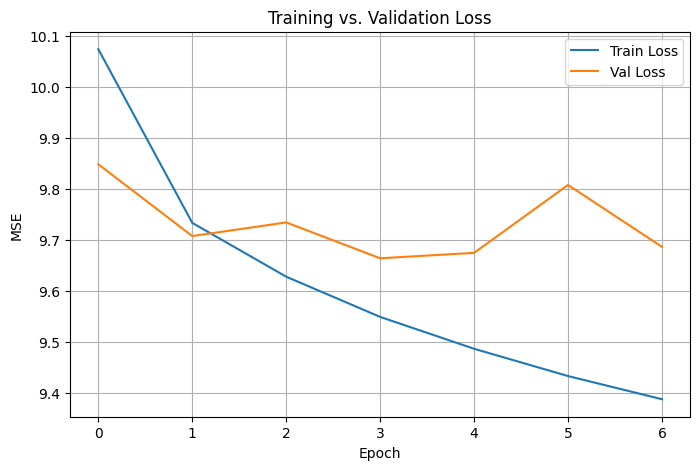

In [72]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Actual vs. Predicted

9091/9091 ━━━━━━━━━━━━━━━━━━━━ 3s 343us/step


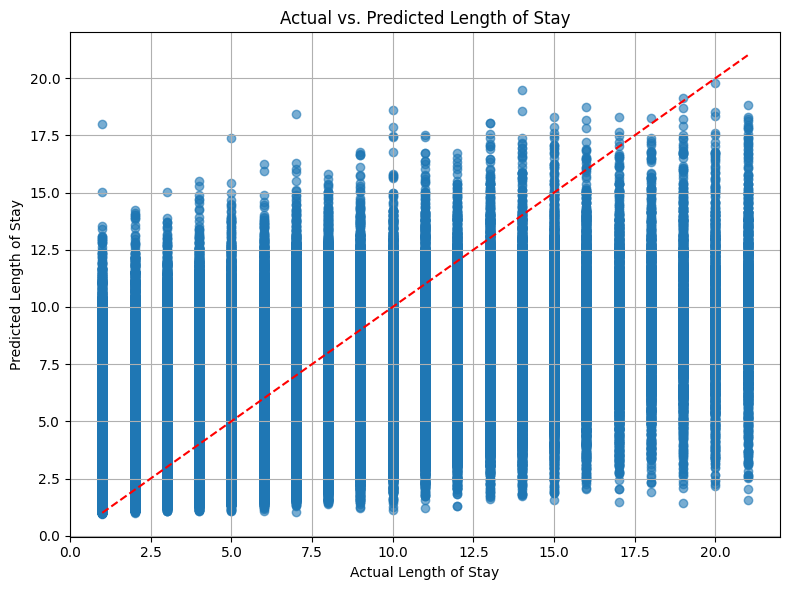

In [73]:
y_pred = model.predict(X_test).flatten()
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual Length of Stay')
plt.ylabel('Predicted Length of Stay')
plt.title('Actual vs. Predicted Length of Stay')
plt.grid(True)
plt.tight_layout()
plt.show()



### Splitting up by gender

9091/9091 ━━━━━━━━━━━━━━━━━━━━ 3s 339us/step


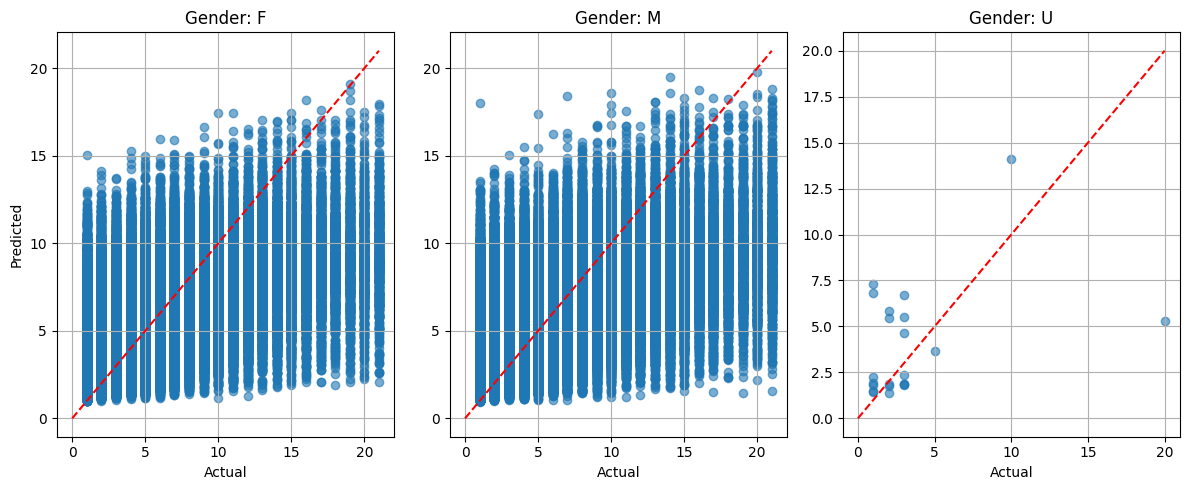

In [74]:
# 1. Create DataFrame with encoded test features and predictions
X_test_df = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())
X_test_df['y_actual'] = y_test.values
X_test_df['y_pred'] = model.predict(X_test).flatten()
# 2. Add gender values from the original DataFrame
X_test_df['gender'] = df.loc[y_test.index, 'gender'].values.flatten()
# 3. Plot Actual vs Predicted for each gender
genders = X_test_df['gender'].unique()
plt.figure(figsize=(12, 5))
for i, gender in enumerate(genders):
    plt.subplot(1, len(genders), i + 1)
    subset = X_test_df[X_test_df['gender'] == gender]
    plt.scatter(subset['y_actual'], subset['y_pred'], alpha=0.6)
    lims = [0, max(subset['y_actual'].max(), subset['y_pred'].max())]
    plt.plot(lims, lims, 'r--')
    plt.title(f"Gender: {gender}")
    plt.xlabel("Actual")
    if i == 0:
        plt.ylabel("Predicted")
    plt.grid(True)
plt.tight_layout()
plt.show()

### Getting MAE Per Gender

In [75]:
# Getting MAE per gender: 

for gender in genders:
    subset = X_test_df[X_test_df['gender'] == gender]
    mae = mean_absolute_error(subset['y_actual'], subset['y_pred'])
    print(f"MAE for gender {gender}: {mae:.2f}")


MAE for gender F: 1.86
MAE for gender M: 2.30
MAE for gender U: 2.57


### Distribution of residuals

/Users/shailivemuri/VS Code/Hospital LOS/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/shailivemuri/VS Code/Hospital LOS/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/shailivemuri/VS Code/Hospital LOS/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


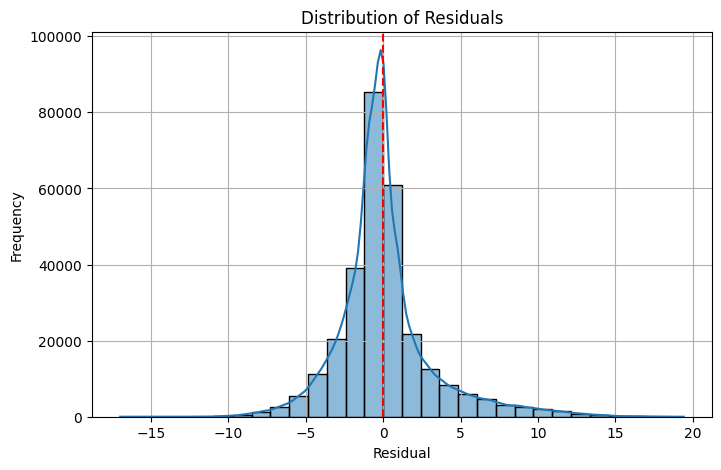

In [76]:
residuals = X_test_df['y_actual'] - X_test_df['y_pred']
X_test_df['error'] = abs(X_test_df['y_actual'] - X_test_df['y_pred'])
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Error length by bins:

/var/folders/cn/yq8hnccx3n309s8g15blkpv80000gp/T/ipykernel_14508/3093194137.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_bin = X_test_df.groupby('bin')['error'].mean()


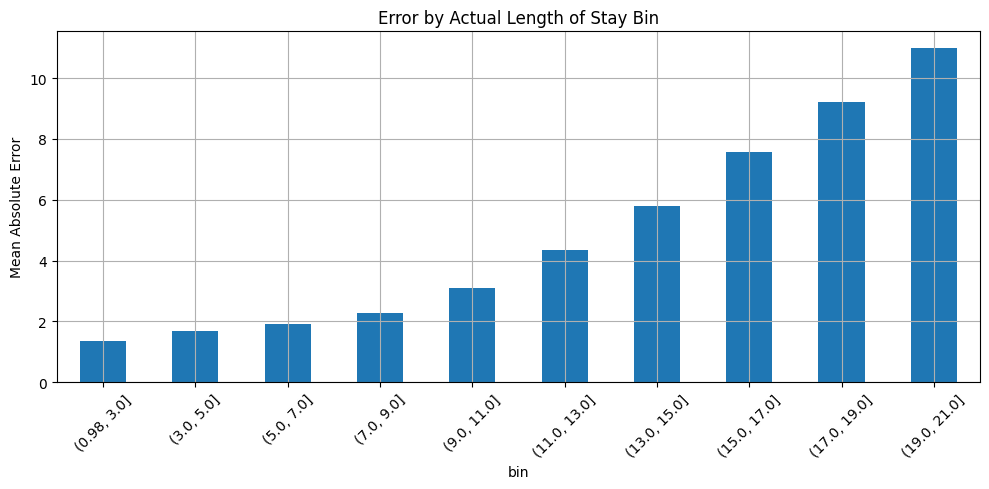

In [77]:
X_test_df['bin'] = pd.cut(X_test_df['y_actual'], bins=10)
error_by_bin = X_test_df.groupby('bin')['error'].mean()
plt.figure(figsize=(10, 5))
error_by_bin.plot(kind='bar')
plt.ylabel('Mean Absolute Error')
plt.title('Error by Actual Length of Stay Bin')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### QQ Residual Plot

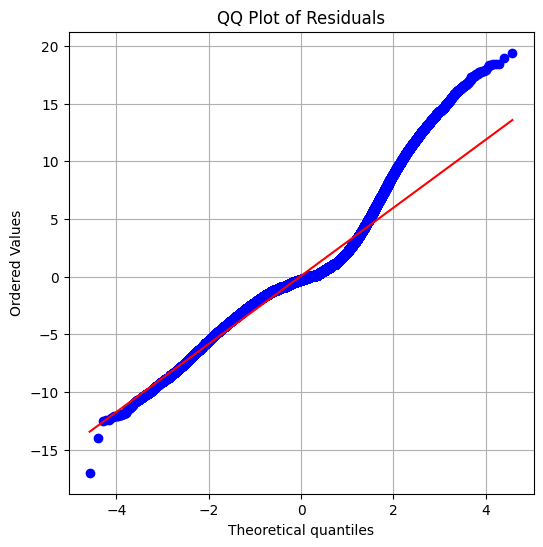

In [78]:
import scipy.stats as stats
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()

### Splitting up by age group

9091/9091 ━━━━━━━━━━━━━━━━━━━━ 3s 342us/step


/var/folders/cn/yq8hnccx3n309s8g15blkpv80000gp/T/ipykernel_14508/1676277965.py:21: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


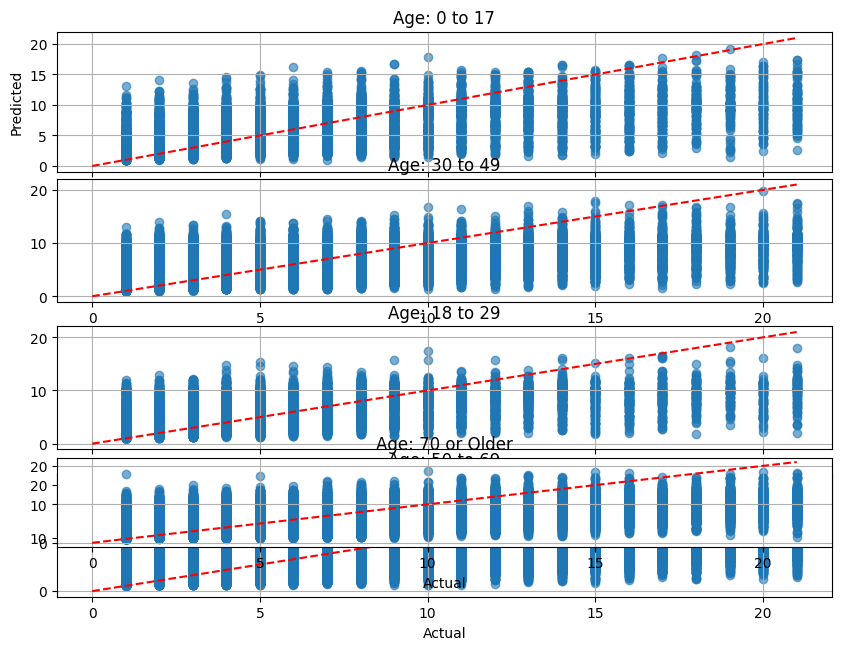

In [80]:
# 1. Create DataFrame with encoded test features and predictions
X_test_df = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())
X_test_df['y_actual'] = y_test.values
X_test_df['y_pred'] = model.predict(X_test).flatten()
# 2. Add gender values from the original DataFrame
X_test_df['age_group'] = df.loc[y_test.index, 'age_group'].values.flatten()
# 3. Plot Actual vs Predicted for each gender
age_groups = X_test_df['age_group'].unique()
plt.figure(figsize=(10, 15))
for i, age_group in enumerate(age_groups):
    plt.subplot(len(age_group), 1 ,i + 1)
    subset = X_test_df[X_test_df['age_group'] == age_group]
    plt.scatter(subset['y_actual'], subset['y_pred'], alpha=0.6)
    lims = [0, max(subset['y_actual'].max(), subset['y_pred'].max())]
    plt.plot(lims, lims, 'r--')
    plt.title(f"Age: {age_group}")
    plt.xlabel("Actual")
    if i == 0:
        plt.ylabel("Predicted")
    plt.grid(True)
plt.tight_layout()
plt.show()

### Getting MAE Per Age Group

In [ ]:
# Getting MAE per age_group:

for age_group in age_groups:
    subset = X_test_df[X_test_df['age_group'] == age_group]
    mae = mean_absolute_error(subset['y_actual'], subset['y_pred'])
    print(f"MAE for age_group {age_group}: {mae:.2f}")


MAE for age_group 0 to 17: 1.16
MAE for age_group 30 to 49: 1.63
MAE for age_group 18 to 29: 1.40
MAE for age_group 50 to 69: 2.43
MAE for age_group 70 or Older: 2.70
